In [1]:
# first, DistanceUnit for the distance between atoms in a molecule:
from qiskit_nature.units import DistanceUnit
# then, PySCFDriver to build our model (pyscf is a quantum chemistry library):
from qiskit_nature.second_q.drivers import PySCFDriver
# now, two solvers: the second one is a generic solver that will use the first
# one to actually solve the problem:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
# finally, a mapper that maps spin operators onto fermionic creation and
# annihilation operators (it'll be used in the solver):
from qiskit_nature.second_q.mappers import JordanWignerMapper

### Helium Molecule

https://medium.com/@avpol111/modeling-an-atom-with-qiskit-ab851b8ff6a5

In [3]:
import numpy as np

distances = np.linspace(0.5, 100, 100)
energies = []

for distance in distances:
    # build the model:
    driver = PySCFDriver(
        atom=f"He 0 0 0; He 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    # it'll return an instance of ElectronicStructureProblem:
    problem = driver.run()

    # and now, let's build a solver, get and print the results:
    solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
    )

    hamiltonian = problem.hamiltonian
    result = solver.solve(problem)
    energies.append(result.groundenergy + hamiltonian.nuclear_repulsion_energy)
    print(result.groundenergy + hamiltonian.nuclear_repulsion_energy)

-3.9337992969131426
-5.596481305671515
-5.615453868630072
-5.615567730871068
-5.6155679150376985
-5.615567915079956
-5.615567915079948
-5.615567915079946
-5.6155679150799465
-5.615567915079947
-5.615567915079947
-5.6155679150799465
-5.6155679150799465
-5.615567915079948
-5.61556791507995
-5.615567915079947
-5.615567915079946
-5.615567915079947
-5.615567915079947
-5.615567915079945
-5.615567915079947
-5.615567915079945
-5.615567915079948
-5.615567915079948
-5.615567915079947
-5.615567915079947
-5.615567915079948
-5.615567915079949
-5.615567915079946
-5.615567915079951
-5.6155679150799465
-5.615567915079947
-5.615567915079945
-5.615567915079948
-5.615567915079945
-5.615567915079947
-5.615567915079947
-5.615567915079947
-5.615567915079949
-5.615567915079947
-5.615567915079947
-5.615567915079949
-5.615567915079949
-5.6155679150799465
-5.615567915079948
-5.61556791507995
-5.615567915079947
-5.615567915079945
-5.61556791507995
-5.61556791507995
-5.615567915079947
-5.615567915079949
-5.615567

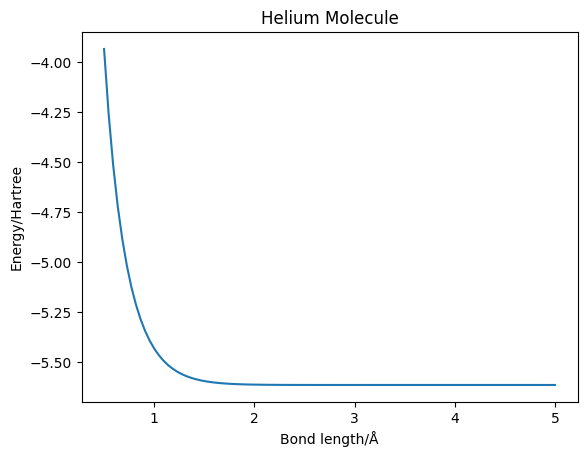

In [3]:
import matplotlib.pyplot as plt

plt.plot(distances, energies, marker='', linestyle='-', label='Exact solution')
plt.xlabel('Bond length/Å')
plt.ylabel('Energy/Hartree')
plt.title('Helium Molecule')
plt.show()

In [4]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

In [5]:
distances = np.linspace(0.25, 4, 10)
energies = []
energies_vqe = []

for distance in distances:
    # build the model:
    driver = PySCFDriver(
        atom=f"He 0 0 0; He 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    # it'll return an instance of ElectronicStructureProblem:
    problem = driver.run()

    # and now, let's build a solver, get and print the results:
    solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
    )

    hamiltonian = problem.hamiltonian
    result = solver.solve(problem)
    energies.append(result.groundenergy + hamiltonian.nuclear_repulsion_energy)


    # VQE:
    mapper = JordanWignerMapper()
    num_orbitals = int(2 * problem.num_particles)

    ansatz = UCCSD(
        num_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            num_orbitals,
            problem.num_particles,
            mapper,
        ),
    )

    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    calc = GroundStateEigensolver(mapper, vqe_solver)
    result_vqe = calc.solve(problem)
    energies_vqe.append(result_vqe.groundenergy + hamiltonian.nuclear_repulsion_energy)


import matplotlib.pyplot as plt

plt.plot(distances, energies, marker='', linestyle='-', label='Exact solution')
plt.plot(distances, energies_vqe, marker='', linestyle='-', label='UCCSD Ansatz')
plt.xlabel('Bond length/Å')
plt.ylabel('Energy/Hartree')
plt.title('Hydrogen Molecule')
plt.legend()
plt.show()

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'tuple'

https://quantumcomputing.stackexchange.com/questions/15755/simulation-of-a-helium-molecule-using-qiskit

In [24]:
from qiskit import IBMQ
#from qiskit.aqua import QuantumInstance
from qiskit.algorithms.optimizers import COBYLA
from qiskit_algorithms import VQE
from qiskit.circuit.library import TwoLocal
#from qiskit.chemistry.qmolecule import QMolecule
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
#from qiskit.chemistry import FermionicOperator
#from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

##### Defining Molecular Structure #######
atom_structure = "He 0. 0. 0.; He 3.1 0. 0"  
[unit, charge, spin, basis]= [DistanceUnit.ANGSTROM, 0, 0, 'sto3g'] 
driver = PySCFDriver(atom= atom_structure, unit=unit,charge=charge, spin=spin, basis=basis)
qmolecule = driver.run()
"""
ferOp = Hamiltonian(transformation = TransformationType.FULL , 
                    qubit_mapping = QubitMappingType.PARITY,
                    two_qubit_reduction = True,
                    freeze_core = True, 
                    orbital_reduction = [ ], 
                    z2symmetry_reduction = None)
"""
ferOp = qmolecule.hamiltonian

##### Exact Diagonalization Result ########
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver


solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
        )

result = solver.solve(problem)

print('THis is the exact result:', result)


##### VQE Result #######
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options
 
tl_circuit = TwoLocal(2, ['h', 'rx'], 'cz',
                      entanglement='full', reps=3, parameter_prefix = 'y')

service = QiskitRuntimeService()
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.get_backend('ibmq_qasm_simulator')
"""
quantum_instance = QuantumInstance(backend,
                                   shots = 8192,
                                   initial_layout = None,
                                   optimization_level = 3) 
"""
options = Options()
options.optimization_level = 3
quantum_instance = Estimator(backend, options=options)

optimizer = COBYLA(maxiter= 100,tol=0.000000001)   
vqe = VQE(result, tl_circuit, optimizer,initial_point= None)
vqe_result = vqe.compute_minimum_eigenvalue(quantum_instance)
print(vqe_result)

THis is the exact result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.703524038229
  - computed part:      -8.703524038229
~ Nuclear repulsion energy (Hartree): 8.46683537472
> Total ground state energy (Hartree): -0.236688663509
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.000 S: 0.500 S^2: 0.750 M: -0.166
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.94486306]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.708647296712]
    - computed part:      [0.0  0.0  0.708647296712]
  > Dipole moment (a.u.): [0.0  0.0  0.236215763288]  Total: 0.236215763288
                 (debye): [0.0  0.0  0.600400526053]  Total: 0.600400526053
 


AttributeError: 'Estimator' object has no attribute 'num_qubits'